## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### In all tables, assume:
* "➊" represents a single hashtag
* "➋" represents a single URL
* "➌" represents a single mention of username (e.g. "@noah")

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.externals import joblib
from nltk.corpus import stopwords
from random import choice
from string import punctuation

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.stats
import itertools
import enchant
import nltk
import json
import re

#### Set up some regex patterns

In [3]:
hashtags_pattern = r'(\#[a-zA-Z0-9]+)'

In [4]:
urls_pattern = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\xab\xbb\u201c\u201d\u2018\u2019]))'


In [5]:
at_mentions_pattern = r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z0-9_]+)'

#### Prepare English dictionary for language detection

In [6]:
english_dict = enchant.Dict("en_US")

#### Use NLTK's tokenizer instead of Scikit's

In [7]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Prepare for viewing long text in CSVs and ones with really big and small numbers

In [8]:
pd.set_option("max_colwidth", 280)

In [9]:
pd.options.display.float_format = "{:.4f}".format

#### Load the two data files

In [10]:
subtweets_data = [t for t in json.load(open("../data/other_data/subtweets.json")) 
                  if t["tweet_data"]["user"]["lang"] == "en" 
                  and t["reply"]["user"]["lang"] == "en"]

In [11]:
non_subtweets_data = [t for t in json.load(open("../data/other_data/non_subtweets.json")) 
                      if t["tweet_data"]["user"]["lang"] == "en" 
                      and t["reply"]["user"]["lang"] == "en"]

#### Only use tweets with at least 5 English words
#### Also, make the mentions of usernames, URLs, and hashtags generic

In [12]:
%%time
subtweets_data = [(re.sub(hashtags_pattern, 
                          "➊", 
                          re.sub(urls_pattern, 
                                 "➋", 
                                 re.sub(at_mentions_pattern, 
                                        "➌", 
                                        t["tweet_data"]["full_text"])))
                   .replace("\u2018", "'")
                   .replace("\u2019", "'")
                   .replace("&quot;", "\"")
                   .replace("&amp;", "&")
                   .replace("&gt;", ">")
                   .replace("&lt;", "<"))
                  for t in subtweets_data 
                  if sum([english_dict.check(token) 
                          for token in tokenizer.tokenize(t["tweet_data"]["full_text"])]) >= 5]

CPU times: user 4.51 s, sys: 1.63 s, total: 6.14 s
Wall time: 6.65 s


In [13]:
%%time
non_subtweets_data = [(re.sub(hashtags_pattern, 
                              "➊", 
                              re.sub(urls_pattern, 
                                     "➋", 
                                     re.sub(at_mentions_pattern, 
                                            "➌", 
                                            t["tweet_data"]["full_text"])))
                       .replace("\u2018", "'")
                       .replace("\u2019", "'")
                       .replace("&quot;", "\"")
                       .replace("&amp;", "&")
                       .replace("&gt;", ">")
                       .replace("&lt;", "<"))
                      for t in non_subtweets_data 
                      if sum([english_dict.check(token) 
                              for token in tokenizer.tokenize(t["tweet_data"]["full_text"])]) >= 5]

CPU times: user 7.59 s, sys: 2.73 s, total: 10.3 s
Wall time: 11.4 s


#### Show examples

In [14]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
i understand following controversial accounts to the point where i'll judge you if your choice is too basic


In [15]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
7 Google Analytics Mistakes That Still Happen Way Too Often ➋ good advice by Mel ➌


#### Find the length of the smaller dataset

In [16]:
smallest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Cut both down to be the same length

In [17]:
subtweets_data = subtweets_data[:smallest_length]

In [18]:
non_subtweets_data = non_subtweets_data[:smallest_length]

In [19]:
print("Smallest dataset length: {}".format(len(non_subtweets_data)))

Smallest dataset length: 7278


#### Prepare data for training

In [20]:
subtweets_data = [(tweet, "subtweet") for tweet in subtweets_data]

In [21]:
non_subtweets_data = [(tweet, "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [22]:
training_data = subtweets_data + non_subtweets_data

#### Create custom stop words to include generic usernames, URLs, and hashtags, as well as common English first names

In [23]:
names_lower = set([name.lower() for name in open("../data/other_data/first_names.txt").read().split("\n")])

In [24]:
generic_tokens = {"➊", "➋", "➌"}

In [25]:
stop_words = text.ENGLISH_STOP_WORDS | names_lower | generic_tokens

#### Build the pipeline

In [26]:
sentiment_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   ngram_range=(1, 3), 
                                   stop_words=stop_words)),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [27]:
text_training_data = np.array([row[0] for row in training_data])

In [28]:
class_training_data = np.array([row[1] for row in training_data])

In [29]:
kf = KFold(n_splits=10, random_state=7, shuffle=True)

In [30]:
%%time
cnf_matrix = np.zeros((2, 2), dtype=int)
for i, (train_index, test_index) in enumerate(kf.split(text_training_data)):
    
    text_train, text_test = text_training_data[train_index], text_training_data[test_index]
    class_train, class_test = class_training_data[train_index], class_training_data[test_index]
    
    sentiment_pipeline.fit(text_train, class_train)
    predictions = sentiment_pipeline.predict(text_test)
        
    cnf_matrix += confusion_matrix(class_test, predictions)
    
    print("Iteration {}".format(i+1))
    print(classification_report(class_test, predictions, digits=3))
    print("accuracy: {:.3f}\n".format(accuracy_score(class_test, predictions)))

Iteration 1
              precision    recall  f1-score   support

non-subtweet      0.755     0.658     0.703       765
    subtweet      0.668     0.764     0.713       691

 avg / total      0.714     0.708     0.708      1456

accuracy: 0.708

Iteration 2
              precision    recall  f1-score   support

non-subtweet      0.723     0.678     0.700       712
    subtweet      0.709     0.751     0.730       744

 avg / total      0.716     0.716     0.715      1456

accuracy: 0.716

Iteration 3
              precision    recall  f1-score   support

non-subtweet      0.687     0.692     0.690       695
    subtweet      0.717     0.712     0.715       761

 avg / total      0.703     0.703     0.703      1456

accuracy: 0.703

Iteration 4
              precision    recall  f1-score   support

non-subtweet      0.719     0.666     0.691       727
    subtweet      0.690     0.741     0.714       729

 avg / total      0.704     0.703     0.703      1456

accuracy: 0.703

Iteratio

#### See the most informative features

In [31]:
def most_informative_features(pipeline, n=20):
    vectorizer = pipeline.named_steps["vectorizer"]
    classifier = pipeline.named_steps["classifier"]
    
    class_labels = classifier.classes_
    
    feature_names = vectorizer.get_feature_names()
    
    top_n_class_1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    top_n_class_2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    return {class_labels[0]: pd.DataFrame({"Weight": [tup[0] for tup in top_n_class_1], 
                                           "Feature": [tup[1] for tup in top_n_class_1]}), 
            class_labels[1]: pd.DataFrame({"Weight": [tup[0] for tup in reversed(top_n_class_2)],
                                           "Feature": [tup[1] for tup in reversed(top_n_class_2)]})}

In [32]:
most_informative_features_all = most_informative_features(sentiment_pipeline)

In [33]:
most_informative_features_non_subtweet = most_informative_features_all["non-subtweet"]

In [34]:
most_informative_features_subtweet = most_informative_features_all["subtweet"]

In [35]:
most_informative_features_non_subtweet.join(most_informative_features_subtweet, 
                                            lsuffix=" (Non-subtweet)", 
                                            rsuffix=" (Subtweet)")

,Feature (Non-subtweet),Weight (Non-subtweet),Feature (Subtweet),Weight (Subtweet)
0,! ! &,-12.6746,.,-7.6327
1,! ! (,-12.6746,",",-7.9706
2,! ! ),-12.6746,people,-8.4275
3,! ! 100,-12.6746,?,-8.5486
4,! ! 15,-12.6746,don't,-8.5798
5,! ! 2-1,-12.6746,like,-8.6100
6,! ! 3,-12.6746,"""",-8.6197
7,! ! 5,-12.6746,just,-8.7128
8,! ! :,-12.6746,i'm,-8.7675
9,! ! :),-12.6746,it's,-8.9806


#### Define function for visualizing confusion matrices

In [36]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title="Confusion Matrix", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted Label")

#### Show the matrices

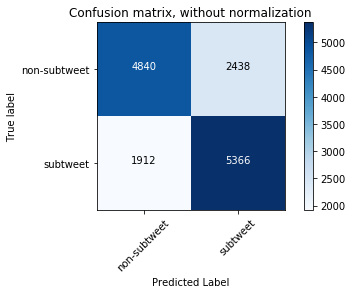

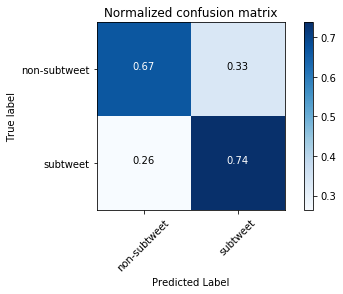

In [37]:
class_names = ["non-subtweet", "subtweet"]

np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Update matplotlib style

In [38]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [39]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [40]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [41]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [42]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Remove usernames, URLs, and hashtags

In [43]:
test_tweets_df["Tweet"] = test_tweets_df["Tweet"].str.replace(hashtags_pattern, "➊")

In [44]:
test_tweets_df["Tweet"] = test_tweets_df["Tweet"].str.replace(urls_pattern, "➋")

In [45]:
test_tweets_df["Tweet"] = test_tweets_df["Tweet"].str.replace(at_mentions_pattern, "➌")

#### Print the tests

In [46]:
tests_dataframe(test_tweets_df, text_column="Tweet", 
                sentiment_column="Sentiment").drop(["sentiment_score", 
                                                    "subtweet_negative_probability"], axis=1).head()

,subtweet_positive_probability,tweet
1,0.8411,Isn't it funny how some people don't know their place?
0,0.8310,Some people don't know their place.
2,0.7141,How come you people act like this?
3,0.6586,You're such a nerd.
4,0.5831,"I love Noah, he's so cool."


#### Tests on friends' tweets

#### Aaron

In [47]:
aaron_df = pd.read_csv("../data/data_for_testing/friends_data/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

#### Remove usernames, URLs, and hashtags

In [48]:
aaron_df["Text"] = aaron_df["Text"].str.replace(hashtags_pattern, "➊")

In [49]:
aaron_df["Text"] = aaron_df["Text"].str.replace(urls_pattern, "➋")

In [50]:
aaron_df["Text"] = aaron_df["Text"].str.replace(at_mentions_pattern, "➌")

In [51]:
aaron_df = tests_dataframe(aaron_df, text_column="Text", 
                           sentiment_column="Sentiment").drop(["sentiment_score", 
                                                               "subtweet_negative_probability"], axis=1)

In [52]:
aaron_df.to_csv("../data/data_from_testing/friends_data/akrapf96_tests.csv")

In [53]:
aaron_df.head()

,subtweet_positive_probability,tweet
2137,0.9228,Also you don't need to resort to social media 24/7 to complain about your very privileged life ¯\_(ツ)_/¯
2151,0.9139,When I try to be supportive and caring I get ignored and then I'm told I'm not being supportive or caring ¯\_(ツ)_/¯
2073,0.9020,"""i do have aids ¯\_(ツ)_/¯. That's what happens when you're super gay"" ➊"
1596,0.8940,¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol
2125,0.8911,¯\_(ツ)_/¯


In [54]:
aaron_df_for_plotting = aaron_df.drop(["tweet"], axis=1)

#### Julia

In [55]:
julia_df = pd.read_csv("../data/data_for_testing/friends_data/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

#### Remove usernames, URLs, and hashtags

In [56]:
julia_df["Text"] = julia_df["Text"].str.replace(hashtags_pattern, "➊")

In [57]:
julia_df["Text"] = julia_df["Text"].str.replace(urls_pattern, "➋")

In [58]:
julia_df["Text"] = julia_df["Text"].str.replace(at_mentions_pattern, "➌")

In [59]:
julia_df = tests_dataframe(julia_df, text_column="Text", 
                           sentiment_column="Sentiment").drop(["sentiment_score", 
                                                               "subtweet_negative_probability"], axis=1)

In [60]:
julia_df.to_csv("../data/data_from_testing/friends_data/juliaeberry_tests.csv")

In [61]:
julia_df.head(5)

,subtweet_positive_probability,tweet
3197,0.8786,unpopular twitter opinion I don't like christine sudoku and elijah whatever and I don't think they're funny
49,0.8648,･ ｡\n ☆∴｡ *\n ･ﾟ*｡★･\n ･ *ﾟ｡ *\n ･ ﾟ*｡･ﾟ★｡\n ☆ﾟ･｡°*. ﾟ\n* ﾟ｡·*･｡ ﾟ*\n ﾟ *.｡☆｡★ ･\n * ☆ ｡･ﾟ*.｡\n * ★ ﾟ･｡ * ｡\n ･ ﾟ☆ ｡➋
50,0.8648,･ ｡\n ☆∴｡ *\n ･ﾟ*｡★･\n ･ *ﾟ｡ *\n ･ ﾟ*｡･ﾟ★｡\n ☆ﾟ･｡°*. ﾟ\n* ﾟ｡·*･｡ ﾟ*\n ﾟ *.｡☆｡★ ･\n * ☆ ｡･ﾟ*.｡\n * ★ ﾟ･｡ * ｡\n ･ ﾟ☆ ｡➋
4257,0.8616,been sitting under a tree with ➌ and ➌ and I have read 7 pages of the book I'm writing my final paper on ¯\_(ツ)_/¯
4342,0.8611,I've never fully understood the appeal of tinder but now friendsy got me hooked so ¯\_(ツ)_/¯


In [62]:
julia_df_for_plotting = julia_df.drop(["tweet"], axis=1)

#### Lex

In [63]:
lex_df = pd.read_csv("../data/data_for_testing/friends_data/gothodile_tweets.csv").dropna()
lex_df["Sentiment"] = None

#### Remove usernames, URLs, and hashtags

In [64]:
lex_df["Text"] = lex_df["Text"].str.replace(hashtags_pattern, "➊")

In [65]:
lex_df["Text"] = lex_df["Text"].str.replace(urls_pattern, "➋")

In [66]:
lex_df["Text"] = lex_df["Text"].str.replace(at_mentions_pattern, "➌")

In [67]:
lex_df = tests_dataframe(lex_df, text_column="Text", 
                         sentiment_column="Sentiment").drop(["sentiment_score",
                                                             "subtweet_negative_probability"], axis=1)

In [68]:
lex_df.to_csv("../data/data_from_testing/friends_data/gothodile_tests.csv")

In [69]:
lex_df.head()

,subtweet_positive_probability,tweet
1043,0.8597,and i realize thats not something i should complain about but it feels kinda evolutionarily inefficiant.
3260,0.8550,"its as bad of an excuse as any to try and say ""if you're a REAL comic book fan you'll like it"""
2054,0.8300,so like literally u can stop tweeting @ me to die because i didnt put an art cred on my relatable meme shitpost
2138,0.8283,wanna know what a real depression mood is?? pinterest. i feel like pinterest is where u go when u dont want to think about anything.
2110,0.8245,needing help on things but not wanting to ask because u know theyre just gonna say some stupid shit and u dont want to go to jail for murder


In [70]:
lex_df_for_plotting = lex_df.drop(["tweet"], axis=1)

#### Noah

In [71]:
noah_df = pd.read_csv("../data/data_for_testing/friends_data/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

#### Remove usernames, URLs, and hashtags

In [72]:
noah_df["Text"] = noah_df["Text"].str.replace(hashtags_pattern, "➊")

In [73]:
noah_df["Text"] = noah_df["Text"].str.replace(urls_pattern, "➋")

In [74]:
noah_df["Text"] = noah_df["Text"].str.replace(at_mentions_pattern, "➌")

In [75]:
noah_df = tests_dataframe(noah_df, text_column="Text", 
                          sentiment_column="Sentiment").drop(["sentiment_score", 
                                                              "subtweet_negative_probability"], axis=1)

In [76]:
noah_df.to_csv("../data/data_from_testing/friends_data/noahsegalgould_tests.csv")

In [77]:
noah_df.head()

,subtweet_positive_probability,tweet
2022,0.8911,you may think you're cool but unless you're friends with my friends you're not actually as cool as you could be
2588,0.8504,"I'm gonna start a political party that exists only to express its members indecisiveness. It will be the ""¯\_(ツ)_/¯"" party."
2027,0.8503,IF U CALL URSELF A WEEB BUT DONT HAVE ANIME PROF PICS ON ALL SOCIAL MEDIA\n DELETE UR ACCOUNTS
1716,0.8440,If you don't make your meatloaf with ketchup don't bother talking to me
1689,0.8345,linkedin is better than twitter.\ndon't @ me.


In [78]:
noah_df_for_plotting = noah_df.drop(["tweet"], axis=1)

#### Rename the columns for later

In [79]:
aaron_df_for_plotting_together = aaron_df_for_plotting.rename(columns={"subtweet_positive_probability": "Aaron"})

In [80]:
julia_df_for_plotting_together = julia_df_for_plotting.rename(columns={"subtweet_positive_probability": "Julia"})

In [81]:
lex_df_for_plotting_together = lex_df_for_plotting.rename(columns={"subtweet_positive_probability": "Lex"})

In [82]:
noah_df_for_plotting_together = noah_df_for_plotting.rename(columns={"subtweet_positive_probability": "Noah"})

#### Prepare statistics on friends' tweets

In [83]:
friends_df = pd.concat([aaron_df_for_plotting_together, 
                        julia_df_for_plotting_together, 
                        lex_df_for_plotting_together, 
                        noah_df_for_plotting_together], ignore_index=True)

In [84]:
friends_df.describe()

,Aaron,Julia,Lex,Noah
count,2640.0000,4356.0000,3488.0000,2814.0000
mean,0.5082,0.5198,0.5279,0.5087
std,0.1212,0.1036,0.1120,0.1097
min,0.1386,0.1274,0.1493,0.1450
25%,0.4251,0.4513,0.4566,0.4374
50%,0.5070,0.5159,0.5219,0.5059
75%,0.5873,0.5863,0.6055,0.5806
max,0.9228,0.8786,0.8597,0.8911


In [85]:
aaron_mean = friends_df.describe().Aaron[1]
aaron_std = friends_df.describe().Aaron[2]

julia_mean = friends_df.describe().Julia[1]
julia_std = friends_df.describe().Julia[2]

noah_mean = friends_df.describe().Noah[1]
noah_std = friends_df.describe().Noah[2]

lex_mean = friends_df.describe().Lex[1]
lex_std = friends_df.describe().Lex[2]

#### Plot all the histograms

/Users/Noah/anaconda/envs/work/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


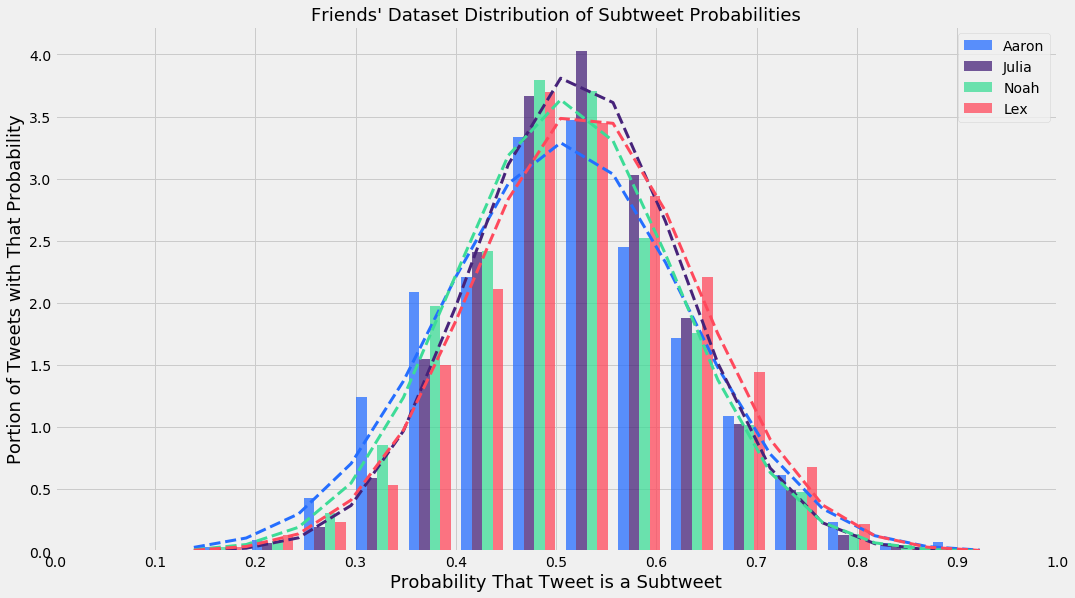

CPU times: user 710 ms, sys: 51.8 ms, total: 762 ms
Wall time: 807 ms


In [86]:
%%time
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist([aaron_df_for_plotting.subtweet_positive_probability, 
                            julia_df_for_plotting.subtweet_positive_probability, 
                            noah_df_for_plotting.subtweet_positive_probability, 
                            lex_df_for_plotting.subtweet_positive_probability], 
                           bins="doane",
                           color=["#256EFF", "#46237A", "#3DDC97", "#FF495C"],
                           density=True, label=["Aaron", "Julia", "Noah", "Lex"], 
                           alpha=0.75)

aaron_line = scipy.stats.norm.pdf(bins, aaron_mean, aaron_std)
ax.plot(bins, aaron_line, "--", color="#256EFF", linewidth=3)

julia_line = scipy.stats.norm.pdf(bins, julia_mean, julia_std)
ax.plot(bins, julia_line, "--", color="#46237A", linewidth=3)

noah_line = scipy.stats.norm.pdf(bins, noah_mean, noah_std)
ax.plot(bins, noah_line, "--", color="#3DDC97", linewidth=3)

lex_line = scipy.stats.norm.pdf(bins, lex_mean, lex_std)
ax.plot(bins, lex_line, "--", color="#FF495C", linewidth=3)

ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Friends' Dataset Distribution of Subtweet Probabilities", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Portion of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Statisitics on training data

#### Remove mentions of usernames for these statistics

In [87]:
training_data = [" ".join([token for token in tokenizer.tokenize(pair[0]) if "@" not in token]) 
                 for pair in training_data]

#### Lengths (Less than or equal to 280 characters and greater than or equal to 5 characters)

In [88]:
length_data = [len(tweet) for tweet in training_data]

In [89]:
length_data_for_stats = pd.DataFrame({"Length": length_data, "Tweet": training_data})

In [90]:
length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] <= 280]  

In [91]:
length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] >= 5]

In [92]:
length_data = length_data_for_stats.Length.tolist()

In [93]:
length_data_for_stats.sort_values(by="Length", ascending=False).head()

,Length,Tweet
3417,280,"i'll never have any respect for trophy hunters . i know there's an argument made about it helping conservation , but shit it's pathetic . it's like buying dlc to fucking clobber the kids that couldn't afford it . there's no sport in it , just spend a ton of money , hide and s..."
5351,280,"so uh , slightly annoying thing but like legitmately , don't just go "" but i / thought / x was the best :/ / "" when i'm on my unpopular opinion thread bc tbh it makes me legitmately never want to speak again . like yes , it's a popular game and you liked it and i'm glad you d..."
4299,280,the corbyn jewish stuff is fucking me up anti semitism is generally bad but its annoying to constantly have to claim lies in order not to be an anti semititic like you cant say ' jews are powerful ' even though thats obviously true and pepo wont even debate you on this just s...
3461,280,"in conclusion , if i'm gonna read about a bunch of kids screwing around at an oxbridge or eton knockoff or w / e , i'm just gonna read brideshead revisited , because sebastian flyte wouldn't giggle about turning tea into whiskey , he would treat getting wasted like it was his..."
1688,280,"when your stupid ass ex runs around telling her dumb ass friends a bunch of bullshit and giving your number to people then you have a bunch of fucking pussies saying if you got a problem meet up with me we can settle it get the fuck out of here , bunch of fucking gunsels get ..."


In [94]:
length_data_for_stats.sort_values(by="Length", ascending=True).head()

,Length,Tweet
10743,11,l i l a c ➋
10612,13,a l m o s t ➋
1796,13,i t s j o k e
5812,14,a rat is a rat
2892,15,i want to die .


In [95]:
length_data_for_stats.describe()

,Length
count,14144.0000
mean,112.7000
std,68.2908
min,11.0000
25%,58.0000
50%,94.0000
75%,154.0000
max,280.0000


#### Punctuation

In [96]:
punctuation_data = [len(set(punctuation).intersection(set(tweet))) for tweet in training_data]

In [97]:
punctuation_data_for_stats = pd.DataFrame({"Punctuation": punctuation_data, "Tweet": training_data})

In [98]:
punctuation_data_for_stats.sort_values(by="Punctuation", ascending=False).head()

,Punctuation,Tweet
6533,13,"if u were killed tomorrow , i wouldnt go 2 ur funeral cuz id b n jail 4 killin da person that killed u ! ... ___ ... / _ = = o ; ; ; ___ [ ] ... ) , — - . ( _ ( __ ) / ... / / ( .. ) ) , — - - "" ... / / ___ / / .. / / ___ / / we true homies we ride together we die together"
10474,11,"[ bang dream girls band party seiyuu profiles arpil 2018 edition ] order of posting : - hello , happy world ( 4/8 ) - roselia ( 4/8 ) - pastel * palettes ( 4/9 ) - afterglow ( 4/9 ) - poppin'party ( 4/10 ) let's go !"
8338,10,"going to go ahead and crown myself the absolute emperor of finding things on menus that sound interesting , deciding i would like to try them , then being told "" i'm sorry sir , that's actually not available ... "" [ then why the # $ % is it on your menuuu - - ]"
12488,9,"billboard hot 100 : ➊ ( - 3 ) tell me you love me , ➌ [ 19 weeks ] . * peak : ➊ *"
10929,9,"self-employed people : have you ever turned to social media to call out a client who is many weeks / months delinquent on a payment ? ( obviously , you're probably burning a bridge with that move , but if they don't pay ... )"


In [99]:
punctuation_data_for_stats.describe()

,Punctuation
count,14556.0000
mean,2.0045
std,1.5377
min,0.0000
25%,1.0000
50%,2.0000
75%,3.0000
max,13.0000


#### Stop words

In [100]:
stop_words_data = [len(set(stopwords.words("english")).intersection(set(tweet.lower()))) 
                   for tweet in training_data]

In [101]:
stop_words_data_for_stats = pd.DataFrame({"Stop words": stop_words_data, "Tweet": training_data})

In [102]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=False).head()

,Stop words,Tweet
0,8,"i don't yet have adequate words to do so , but someday i wanna write about the beautiful dance which happens in google docs between a writer & a good editor working simultaneously towards a deadline . when it's working , it's a beautiful dance — though no one really sees it ."
8602,8,thanks for today boys 💋 i'll be back on ➌ ➌ ➌ tomorrow 12-8 pm ❤ ️ can't wait to show you my new lingerie ... and more 😏 ➋
8593,8,mlb radar with a good sampling of approaching storms . some gusty winds expected along with heavy rain and frequent lightning . ➊ ➋
8594,8,"me being under the weather is clearlysetting lo off . she's defiant , loving , tearful , angry , touchy feely + clingy . she's ripping tiny pieces of the wallpaper off in her room . i'm struggling to feel any patience with it cos i feel rough . sigh . that's all . sigh . ➊ ➊"
8595,8,"much of the chattering class said ➌ would lose the election , but he won ; said he'd hurt the economy , but it's booming ; said tax cuts would fail , but they passed , creating more jobs & higher wages ; and said he'd weaken america , but our military is now stronger than ever"


In [103]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=True).head()

,Stop words,Tweet
10778,1,book cover no . 12 ➊ ➊ ➊ ➊ ➋ ➋
3819,2,"beep boop boner : too beep , too boner"
13627,2,yes yes yes yes yes yes ➋
6132,2,drive drive drive drive drive ➋
13707,2,➌ leg work pt . 2 ? ?


In [104]:
stop_words_data_for_stats.describe()

,Stop words
count,14556.0000
mean,7.4009
std,0.9266
min,1.0000
25%,7.0000
50%,8.0000
75%,8.0000
max,8.0000


#### Unique words (at least 2)

In [105]:
unique_words_data = [len(set(tokenizer.tokenize(tweet))) for tweet in training_data]

In [106]:
unique_words_data_for_stats = pd.DataFrame({"Unique words": unique_words_data, "Tweet": training_data})

In [107]:
# unique_words_data_for_stats = unique_words_data_for_stats[unique_words_data_for_stats["Unique words"] >= 2]

In [108]:
unique_words_data = unique_words_data_for_stats["Unique words"].tolist()

In [109]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=False).head()

,Tweet,Unique words
13039,"give away ! the rules are really easy , all you have to do is : 1 . must be following me ( i check ) 2 . rt and fav this tweet 3 . tag your mutuals / anyone 4 . only 1 winner ! 5 . i ship worldwide ;) it ends in 8th may 2018 or when this tweet hit 2k rt and like ! good luck !...",60
4513,"got into a tepid back nd forth w / a uknowwhoaj + columnist bc i said they steal their "" hot takes "" from blk twitter & alike . wallahi my bdeshi ass did not sign up 4 this app to be called asinine by a 30yrold pakistani whos whole politics is post colonial memes for oriental...",57
10764,"thought i'd bring this back ... ➊ and no , i'm not talking about myself here . i wish just once i'd be so bored with my life that i'd find the time to bash people / celebs i don't like .. i mean if i despise someone that much , why still watch his / her every move ? 🤦 ‍ ♀ ️ ➋",57
6502,"crazy how wrong u can be about someone . a girl i graduated w / was always doing drugs & got pregnant at 16 . i assumed she'd end up being a loser but it turn out she now has 4 beautiful kids & is making over $ 4,500 / month just off of child support payments from the 3 diffe...",57
12467,"- many 👮 ‍ ♂ ️ suffer in silence , not always by choice but by design ! ➊ can be a career killer & worse many pd's do not see p . t . s . d as an insured disability ; this has to change 🆘 - hiding mine for 3 years made my ➊ unbearable ! please help us ➊ & ➊ ⚖ ️ ➋",56


In [110]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=True).head()

,Tweet,Unique words
13627,yes yes yes yes yes yes ➋,2
6132,drive drive drive drive drive ➋,2
788,this this this this this this ➋,2
5812,a rat is a rat,3
5363,she's whipped your honor,4


In [111]:
unique_words_data_for_stats.describe()

,Unique words
count,14556.0000
mean,21.2712
std,11.4486
min,2.0000
25%,12.0000
50%,18.0000
75%,29.0000
max,60.0000


#### Plot them

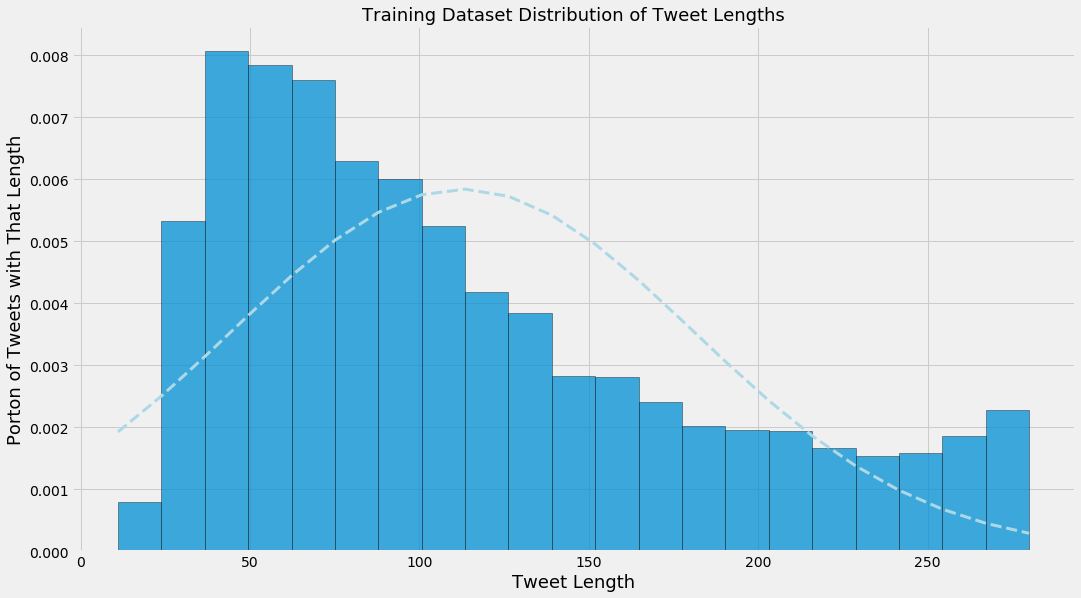

In [112]:
length_mean = length_data_for_stats.describe().Length[1]
length_std = length_data_for_stats.describe().Length[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(length_data, bins="doane", edgecolor="black", density=True, alpha=0.75)

length_line = scipy.stats.norm.pdf(bins, length_mean, length_std)
ax.plot(bins, length_line, "--", linewidth=3, color="lightblue")

ax.set_title("Training Dataset Distribution of Tweet Lengths", fontsize=18)
ax.set_xlabel("Tweet Length", fontsize=18);
ax.set_ylabel("Porton of Tweets with That Length", fontsize=18);

plt.show()

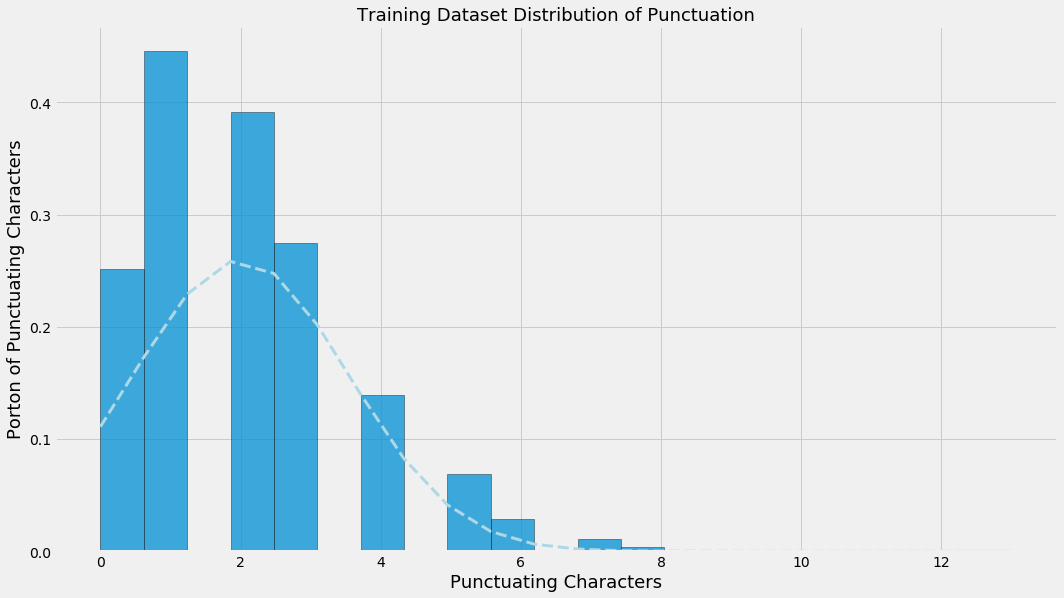

In [113]:
punctuation_mean = punctuation_data_for_stats.describe().Punctuation[1]
punctuation_std = punctuation_data_for_stats.describe().Punctuation[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(punctuation_data, bins="doane", edgecolor="black", density=True, alpha=0.75)

punctution_line = scipy.stats.norm.pdf(bins, punctuation_mean, punctuation_std)
ax.plot(bins, punctution_line, "--", linewidth=3, color="lightblue")

ax.set_title("Training Dataset Distribution of Punctuation", fontsize=18)
ax.set_xlabel("Punctuating Characters", fontsize=18)
ax.set_ylabel("Porton of Punctuating Characters", fontsize=18)

plt.show()

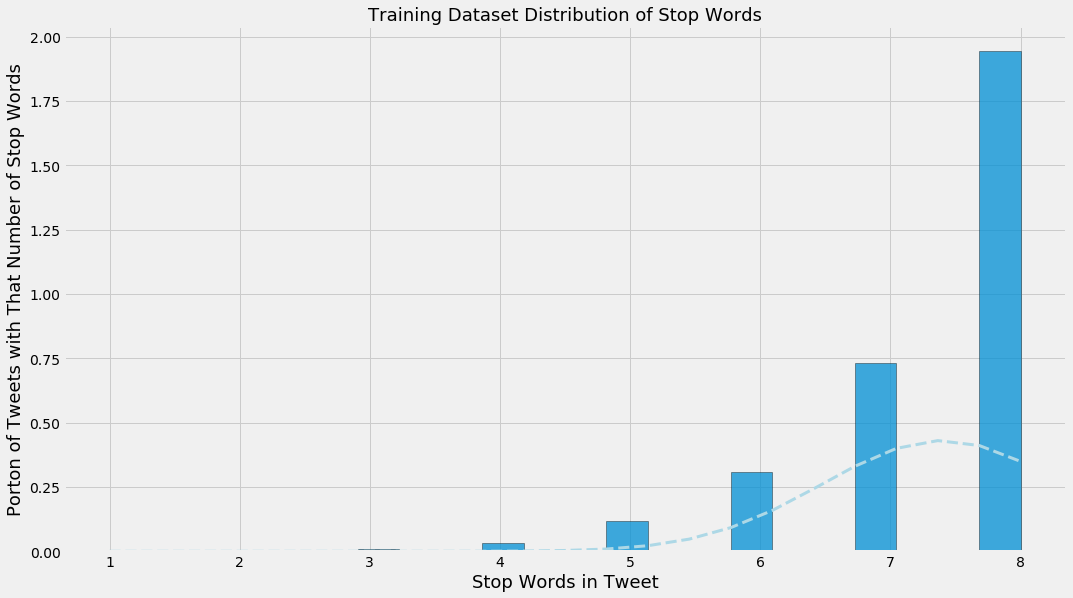

In [114]:
stop_words_mean = stop_words_data_for_stats.describe()["Stop words"][1]
stop_words_std = stop_words_data_for_stats.describe()["Stop words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(stop_words_data, bins="doane", edgecolor="black", density=True, alpha=0.75)

stop_words_line = scipy.stats.norm.pdf(bins, stop_words_mean, stop_words_std)
ax.plot(bins, stop_words_line, "--", linewidth=3, color="lightblue")

ax.set_title("Training Dataset Distribution of Stop Words", fontsize=18)
ax.set_xlabel("Stop Words in Tweet", fontsize=18)
ax.set_ylabel("Porton of Tweets with That Number of Stop Words", fontsize=18)

plt.show()

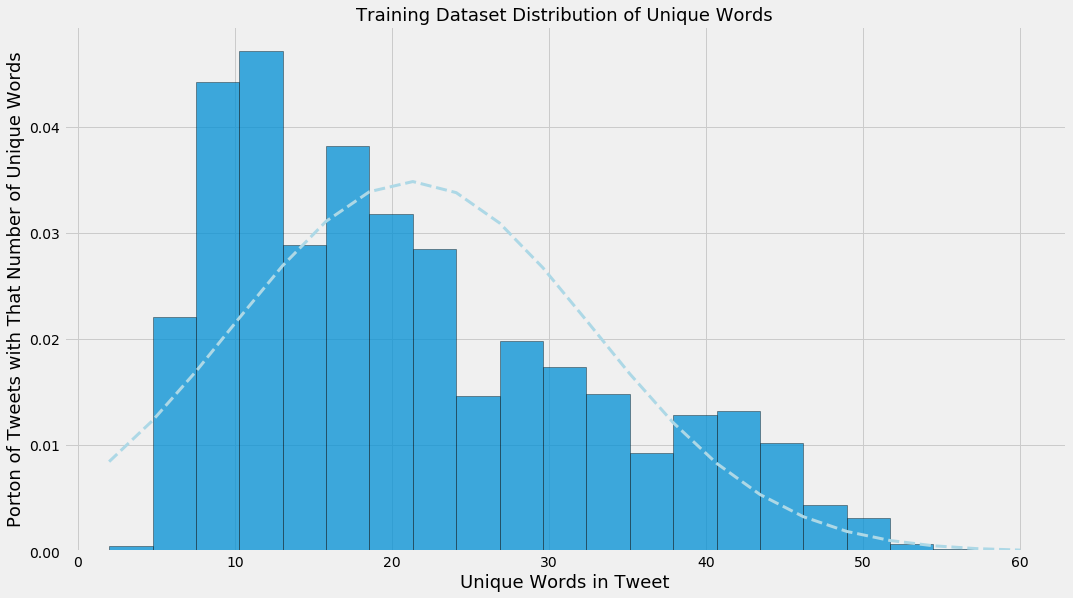

In [115]:
unique_words_mean = unique_words_data_for_stats.describe()["Unique words"][1]
unique_words_std = unique_words_data_for_stats.describe()["Unique words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(unique_words_data, bins="doane", edgecolor="black", density=True, alpha=0.75)

unique_words_line = scipy.stats.norm.pdf(bins, unique_words_mean, unique_words_std)
ax.plot(bins, unique_words_line, "--", linewidth=3, color="lightblue")

ax.set_title("Training Dataset Distribution of Unique Words", fontsize=18)
ax.set_xlabel("Unique Words in Tweet", fontsize=18)
ax.set_ylabel("Porton of Tweets with That Number of Unique Words", fontsize=18)

plt.show()